In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn scipy


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import parallel_coordinates

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set(style="whitegrid")

RANDOM_STATE = 42


In [6]:
df = pd.read_csv("Mall_Customers.csv")
print("Taille :", df.shape)
display(df.head())


Taille : (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
print("\n== Info ==")
print(df.info())

print("\n== Statistiques descriptives ==")
display(df.describe(include="all"))



== Info ==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

== Statistiques descriptives ==


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


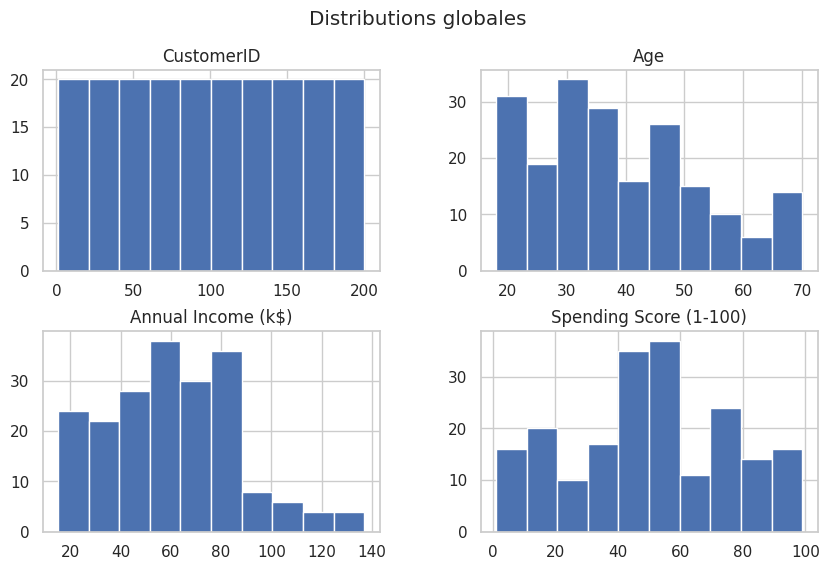

In [9]:
df.hist(figsize=(10,6))
plt.suptitle("Distributions globales")
plt.show()


In [10]:
# 3) Nettoyage léger
# - Vérification des doublons / valeurs manquantes
print("\n== Valeurs manquantes ==")
print(df.isna().sum())

print("\n== Doublons ==")
print(df.duplicated().sum())
# code pour supprimer les doublon df = df.drop_duplicates()


# On gardera 'Gender','Age','Annual Income (k$)','Spending Score (1-100)'
# CustomerID ne sert pas au clustering -> on l'enlève des features.
df_clean = df.copy()
df_clean["Gender"] = df_clean["Gender"].map({"Male": 0, "Female": 1})  # encodage binaire simple

features = ["Gender","Age","Annual Income (k$)","Spending Score (1-100)"]
X = df_clean[features].copy()



== Valeurs manquantes ==
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

== Doublons ==
0


In [11]:
X.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


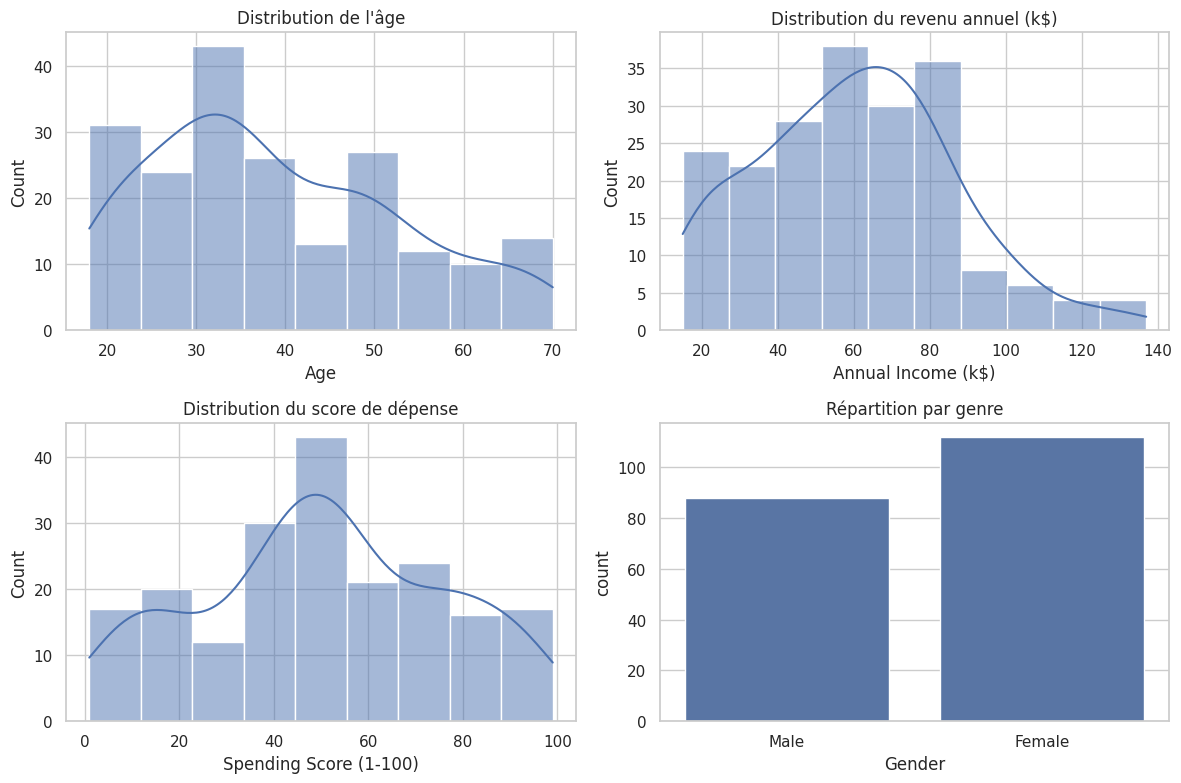

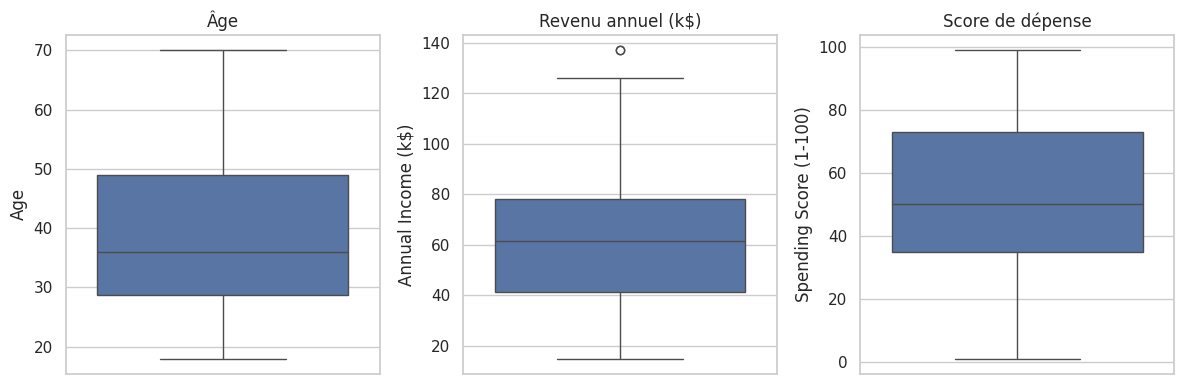

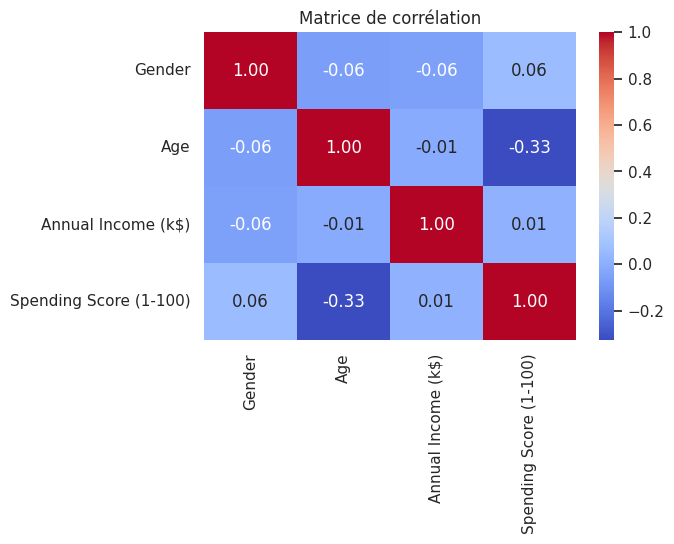

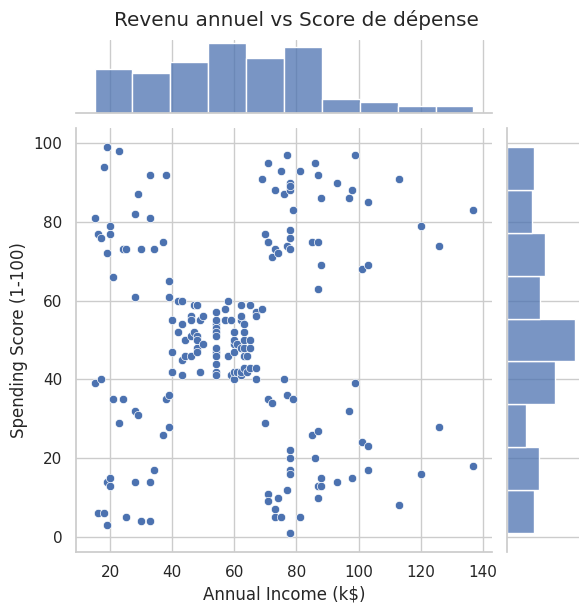

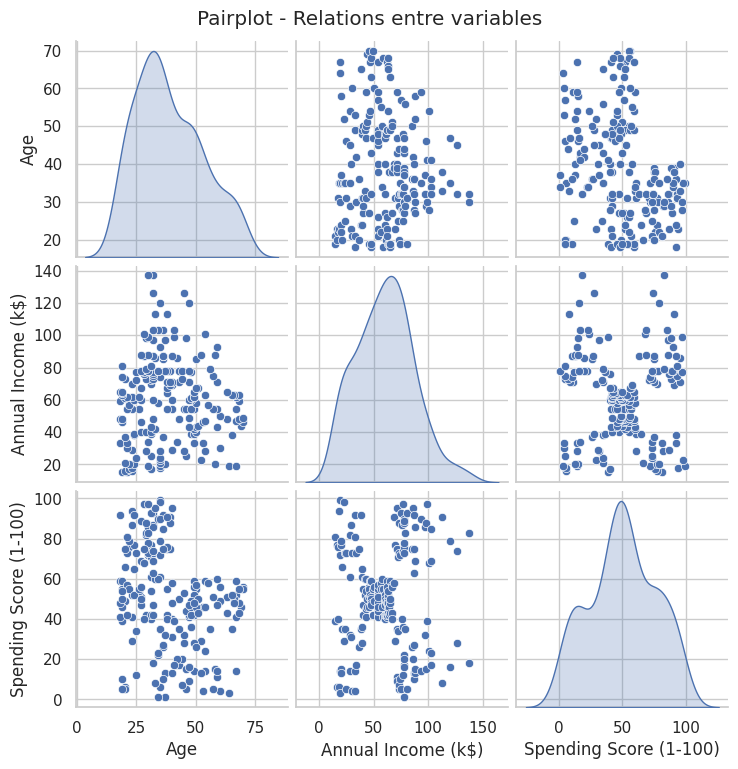

Avant standardisation (extraits) :
   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       0   19                  15                      39
1       0   21                  15                      81
2       1   20                  16                       6

Après standardisation (premières lignes) :
[[-1.12815215 -1.42456879 -1.73899919 -0.43480148]
 [-1.12815215 -1.28103541 -1.73899919  1.19570407]
 [ 0.88640526 -1.3528021  -1.70082976 -1.71591298]]


In [12]:
# ==============================================================
# ÉTAPE 4 - EXPLORATION DES DONNÉES (EDA) + STANDARDISATION
# Objectif :
#   - Visualiser la répartition et les relations entre les variables
#   - Identifier les valeurs extrêmes (outliers)
#   - Préparer les données avec une mise à l’échelle (standardisation)
# ==============================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------------
# 4.1. DISTRIBUTIONS UNI-VARIÉES
# --------------------------------------------------------------
# But : observer la répartition de chaque variable pour comprendre
#       la structure des données (âge, revenu, dépenses, genre).

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histogramme + courbe de densité pour l'âge
sns.histplot(df_clean["Age"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution de l'âge")

# Histogramme + courbe de densité pour le revenu annuel
sns.histplot(df_clean["Annual Income (k$)"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution du revenu annuel (k$)")

# Histogramme + courbe de densité pour le score de dépense
sns.histplot(df_clean["Spending Score (1-100)"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution du score de dépense")

# Comptage du nombre d'hommes et de femmes
sns.countplot(
    x="Gender",
    data=df_clean.replace({"Gender": {0: "Male", 1: "Female"}}),
    ax=axes[1, 1]
)
axes[1, 1].set_title("Répartition par genre")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 4.2. DÉTECTION D’OUTLIERS AVEC DES BOXPLOTS
# --------------------------------------------------------------
# But : repérer visuellement les valeurs extrêmes (points isolés)
#       pour chaque variable numérique.

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(y=df_clean["Age"], ax=axes[0])
axes[0].set_title("Âge")

sns.boxplot(y=df_clean["Annual Income (k$)"], ax=axes[1])
axes[1].set_title("Revenu annuel (k$)")

sns.boxplot(y=df_clean["Spending Score (1-100)"], ax=axes[2])
axes[2].set_title("Score de dépense")

plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 4.3. MATRICE DE CORRÉLATION
# --------------------------------------------------------------
# But : mesurer les liens (corrélations) entre les variables.
#       Si deux variables sont très corrélées, elles apportent
#       souvent la même information au modèle.

corr = df_clean[["Gender", "Age", "Annual Income (k$)", "Spending Score (1-100)"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

# --------------------------------------------------------------
# 4.4. RELATIONS ENTRE VARIABLES (SCATTER / PAIRPLOT)
# --------------------------------------------------------------
# But : visualiser les relations entre deux variables à la fois
#       et vérifier si certains groupes se distinguent naturellement.

# Nuage de points simple : Revenu vs Score de dépense
sns.jointplot(
    data=df_clean,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    kind="scatter",
    height=6
)
plt.suptitle("Revenu annuel vs Score de dépense", y=1.02)
plt.show()

# Pairplot : montre toutes les relations croisées + distributions diagonales
sns.pairplot(
    df_clean[["Age", "Annual Income (k$)", "Spending Score (1-100)"]],
    diag_kind="kde"
)
plt.suptitle("Pairplot - Relations entre variables", y=1.02)
plt.show()

# --------------------------------------------------------------
# 4.5. STANDARDISATION (MISE À L'ÉCHELLE)
# --------------------------------------------------------------
# But : normaliser les variables pour que toutes aient
#       la même échelle (moyenne = 0, écart-type = 1)
#       → indispensable pour le clustering K-Means

# Création d'un objet StandardScaler
scaler = StandardScaler()

# Apprentissage des moyennes/écarts-types et transformation des données
X_scaled = scaler.fit_transform(X)

# Vérification avant/après transformation
print("Avant standardisation (extraits) :")
print(X.head(3))

print("\nAprès standardisation (premières lignes) :")
print(X_scaled[:3])


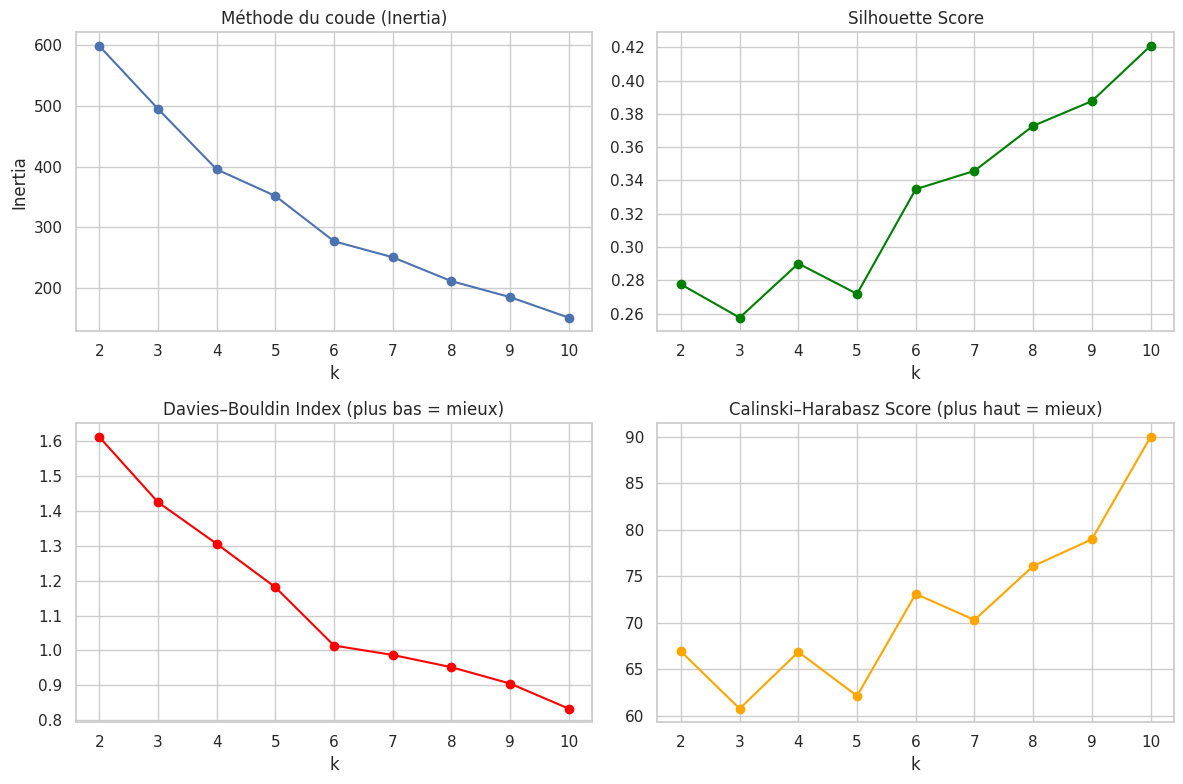

In [13]:
# ==============================================================
# ÉTAPE 5 - CHOIX DU NOMBRE DE CLUSTERS (K)
# Objectif :
#   - Utiliser plusieurs métriques pour estimer le k optimal
# ==============================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# On va tester plusieurs valeurs de k (de 2 à 10)
K = range(2, 11)

# On stocke les scores pour comparaison
inertias = []         # méthode du coude (intra-cluster variance)
silhouettes = []      # silhouette (plus c’est haut, mieux c’est)
db_scores = []        # Davies-Bouldin (plus c’est bas, mieux c’est)
ch_scores = []        # Calinski-Harabasz (plus c’est haut, mieux c’est)

for k in K:
    # Initialisation du modèle KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")

    # Entraînement du modèle sur les données standardisées
    labels = km.fit_predict(X_scaled)

    # Calcul des métriques
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# --------------------------------------------------------------
# Visualisation des résultats pour choisir le meilleur k
# --------------------------------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(12,8))

# Méthode du coude
ax[0,0].plot(K, inertias, marker="o")
ax[0,0].set_title("Méthode du coude (Inertia)")
ax[0,0].set_xlabel("k")
ax[0,0].set_ylabel("Inertia")

# Score de silhouette
ax[0,1].plot(K, silhouettes, marker="o", color="green")
ax[0,1].set_title("Silhouette Score")
ax[0,1].set_xlabel("k")

# Davies-Bouldin
ax[1,0].plot(K, db_scores, marker="o", color="red")
ax[1,0].set_title("Davies–Bouldin Index (plus bas = mieux)")
ax[1,0].set_xlabel("k")

# Calinski–Harabasz
ax[1,1].plot(K, ch_scores, marker="o", color="orange")
ax[1,1].set_title("Calinski–Harabasz Score (plus haut = mieux)")
ax[1,1].set_xlabel("k")

plt.tight_layout()
plt.show()



== DataFrame avec les clusters (k=5) ==


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,0,19,15,39,2
1,2,0,21,15,81,2
2,3,1,20,16,6,4
3,4,1,23,16,77,4
4,5,1,31,17,40,4



== Profilage des clusters (moyennes par variable) ==


,Gender,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,0.490196,56.470588,46.098039,39.313725
1,0.000000,39.500000,85.150000,14.050000
2,0.000000,28.690476,60.904762,70.238095
3,1.000000,37.897959,82.122449,54.448980
4,1.000000,27.315789,38.842105,56.210526



== Répartition des clients par cluster ==
Cluster
0    51
1    20
2    42
3    49
4    38
Name: count, dtype: int64


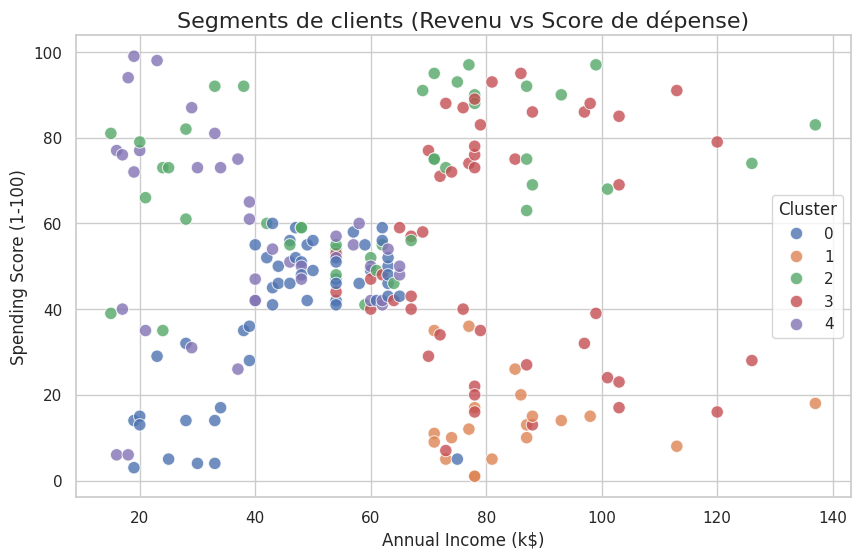

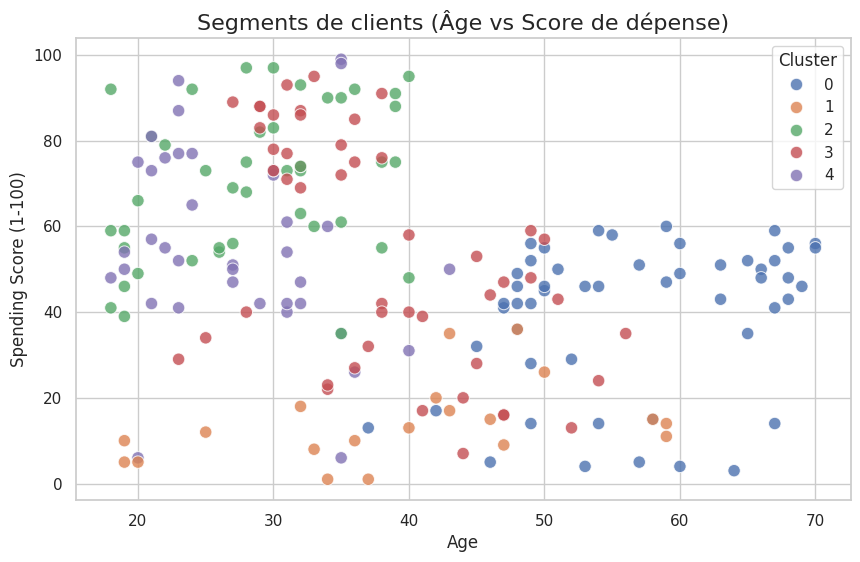


== Pairplot final des clusters ==


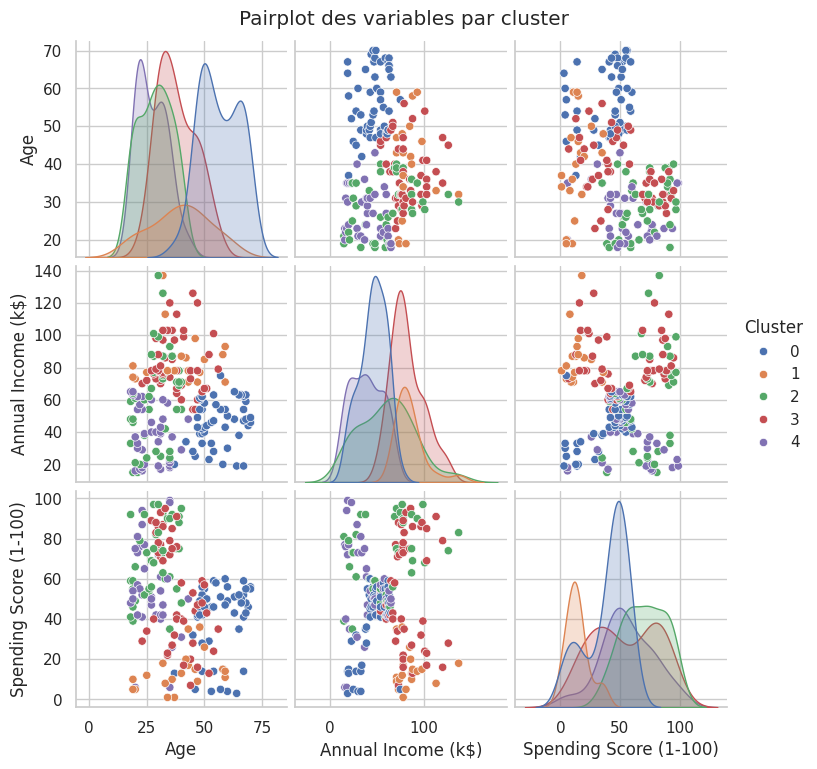


== Boxplots des variables par cluster ==


/tmp/ipython-input-3389757274.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Cluster', y='Age', ax=axes[0], palette="deep")
/tmp/ipython-input-3389757274.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Cluster', y='Annual Income (k$)', ax=axes[1], palette="deep")
/tmp/ipython-input-3389757274.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Cluster', y='Spending Score (1-100)', ax=axes[2], palette="deep")


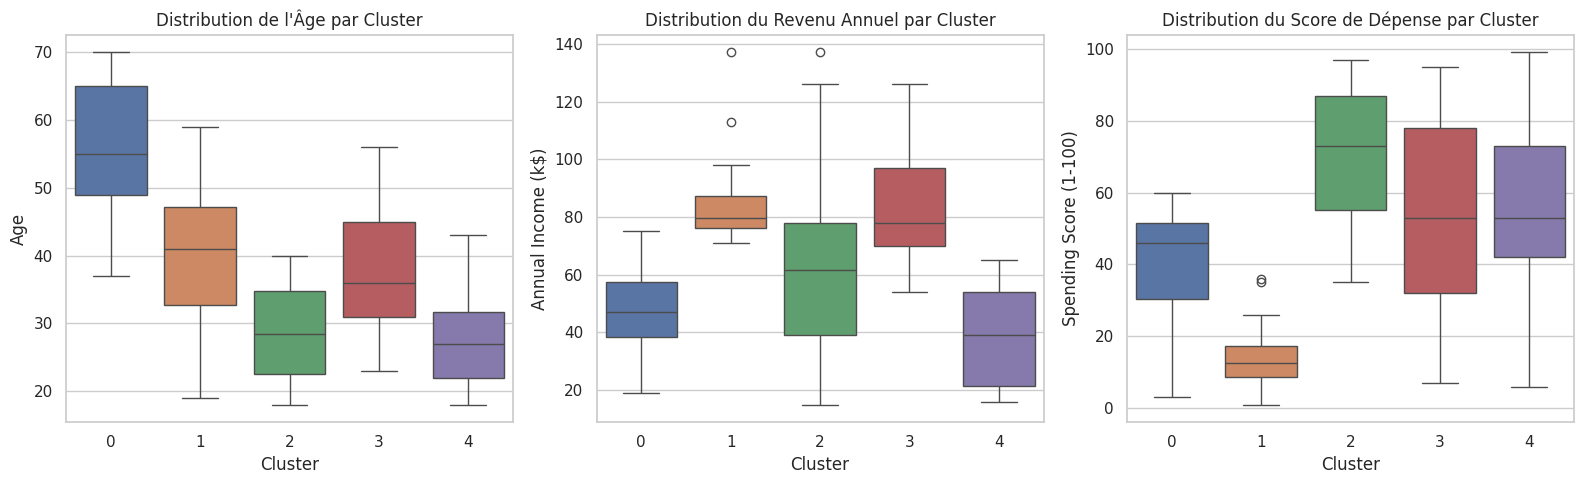

In [14]:
# ==============================================================
# ÉTAPE 6 - ENTRAÎNEMENT DU MODÈLE FINAL ET PROFILAGE
# Objectif :
#   - Appliquer K-Means avec le k optimal (k=5)
#   - Analyser les caractéristiques moyennes de chaque cluster
# ==============================================================

# On choisit le k optimal identifié à l'étape 5
K_OPTIMAL = 5

# 1. Entraînement du modèle K-Means final
kmeans_final = KMeans(
    n_clusters=K_OPTIMAL,
    random_state=RANDOM_STATE,
    n_init="auto"
)
kmeans_final.fit(X_scaled)

# 2. Ajout des labels de cluster au DataFrame original
#    (On utilise df_clean pour avoir les valeurs non standardisées)
df_clean['Cluster'] = kmeans_final.labels_

print(f"\n== DataFrame avec les clusters (k={K_OPTIMAL}) ==")
display(df_clean.head())

# 3. Analyse des caractéristiques moyennes de chaque cluster
#    C'est l'étape la plus importante : le PROFILAGE
print("\n== Profilage des clusters (moyennes par variable) ==")
# On utilise les features d'origine pour l'interprétation
features_with_cluster = features + ['Cluster']
cluster_profile = df_clean[features_with_cluster].groupby('Cluster').mean()
display(cluster_profile)

# On peut aussi regarder la taille de chaque cluster
print("\n== Répartition des clients par cluster ==")
print(df_clean['Cluster'].value_counts().sort_index())


# ==============================================================
# ÉTAPE 7 - VISUALISATION DES CLUSTERS
# Objectif :
#   - Visualiser les segments de clients identifiés
# ==============================================================

# 1. Visualisation principale : Revenu vs Score de dépense
#    C'est le graphique le plus célèbre pour ce jeu de données
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",
    palette="deep",  # Utilise une palette de couleurs distinctes
    s=80,
    alpha=0.8
)
plt.title("Segments de clients (Revenu vs Score de dépense)", fontsize=16)
plt.legend(title="Cluster")
plt.show()

# 2. Visualisation complémentaire : Âge vs Score de dépense
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x="Age",
    y="Spending Score (1-100)",
    hue="Cluster",
    palette="deep",
    s=80,
    alpha=0.8
)
plt.title("Segments de clients (Âge vs Score de dépense)", fontsize=16)
plt.legend(title="Cluster")
plt.show()

# 3. Pairplot pour une vue d'ensemble (coloré par cluster)
#    Permet de voir toutes les relations croisées
print("\n== Pairplot final des clusters ==")
sns.pairplot(
    df_clean,
    hue="Cluster",
    vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"],
    palette="deep",
    diag_kind="kde" # Ajoute des courbes de densité sur la diagonale
)
plt.suptitle("Pairplot des variables par cluster", y=1.02)
plt.show()

# 4. Boxplots pour comparer les distributions par cluster
print("\n== Boxplots des variables par cluster ==")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.boxplot(data=df_clean, x='Cluster', y='Age', ax=axes[0], palette="deep")
axes[0].set_title("Distribution de l'Âge par Cluster")

sns.boxplot(data=df_clean, x='Cluster', y='Annual Income (k$)', ax=axes[1], palette="deep")
axes[1].set_title("Distribution du Revenu Annuel par Cluster")

sns.boxplot(data=df_clean, x='Cluster', y='Spending Score (1-100)', ax=axes[2], palette="deep")
axes[2].set_title("Distribution du Score de Dépense par Cluster")

plt.tight_layout()
plt.show()